# Velocity-Wing deflection surrogate

This file contains the procedures on obtaining a surrogate \
Date: 30/03/22

First read the data inputs

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
data_pandas = pd.read_csv('vel_wing_def.csv') 

In [3]:
data_pandas.head()

,Unnamed: 0,vel,wing_Def
0,0,3.0,0.000484
1,1,8.0,0.003449
2,2,13.0,0.009144
3,3,18.0,0.017634
4,4,23.0,0.028977


Extract the data inputs from the pandas DataFrame

In [4]:
data_numpy = data_pandas.to_numpy()

In [5]:
print(data_numpy)

[[0.00000000e+00 3.00000000e+00 4.83950909e-04]
 [1.00000000e+00 8.00000000e+00 3.44905968e-03]
 [2.00000000e+00 1.30000000e+01 9.14429613e-03]
 [3.00000000e+00 1.80000000e+01 1.76341534e-02]
 [4.00000000e+00 2.30000000e+01 2.89770754e-02]
 [5.00000000e+00 2.80000000e+01 4.32132117e-02]
 [6.00000000e+00 3.30000000e+01 6.03253630e-02]]


Transfer columns to individual numpy variables

In [6]:
AR = 10.0
winglt_length = 4.0
winglt_dhdrl  = 20*np.pi/180
wing_chord    = 1.0
index = data_numpy[:,0]
vel = data_numpy[:,1]
wing_def = data_numpy[:,2]
semi_span = 0.5*AR*wing_chord-winglt_length*np.cos(winglt_dhdrl)

Do a non-dimensionalisation wrt. wing semi_span. Could look in literature how other people have done it

In [7]:
wingDef_nonDim = wing_def/semi_span
print(wingDef_nonDim)

[0.0003899  0.00277874 0.00736713 0.014207   0.02334546 0.03481484
 0.0486013 ]


## Split the data into training and testing

In [12]:
# Set pair values for training and odd to testing
# For now do it manually as I cannot be asked to do it by coding (What a blasfemy!)
vel_train = vel[[0,2,4,6]]
wingDef_nonDim_train = wingDef_nonDim[[0,2,4,6]]

vel_test = vel[[1,3,5]]
wingDef_nonDim_test = wingDef_nonDim[[1,3,5]]

## Plot results

Text(0.5, 0, 'Uinf (m/s)')

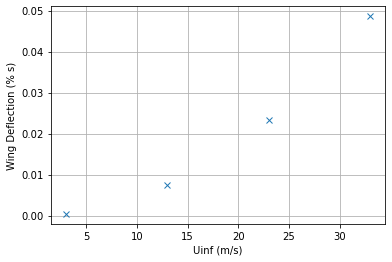

In [13]:
fig = plt.figure()
ax  = fig.add_subplot(1,1,1)
plt.plot(vel_train,wingDef_nonDim_train,'x')
ax.grid(True)
ax.set_ylabel('Wing Deflection (% s)')
ax.set_xlabel('Uinf (m/s)')

## Curve Fitting

First approach is to use a polynomial, can try various degrees e.g 2nd order, 3rd order etc... Note that 4th order should give zero error at the training data points


In [14]:
def polynomial_basis(k,x):
    """Evaluates vector x using a kth degree polynomial.

    Args:
        k      (int): Degree of polynomial to be used
        x (np.array): Vector of points to be evaluated

    Returns:
        b (np.array): 2D array with evaluations of x for 

    """
    num = x.size
    b = np.zeros([num,k+1])
    b[:,0] = 1
    for i in range(num):
        for j in range(k):
            b[i,j+1] = x[i]**(j+1)
    return b
        
    

Test the function 

In [15]:
k = 2
x = vel_train
b = polynomial_basis(k,x)
print(b)

[[1.000e+00 3.000e+00 9.000e+00]
 [1.000e+00 1.300e+01 1.690e+02]
 [1.000e+00 2.300e+01 5.290e+02]
 [1.000e+00 3.300e+01 1.089e+03]]


In [17]:
test = np.zeros([len(x),k+1])
test[:,0] = 1

for i in range(len(x)):
    for j in range(k):
        test[i,j+1] = x[i]
print(test)

[[ 1.  3.  3.]
 [ 1. 13. 13.]
 [ 1. 23. 23.]
 [ 1. 33. 33.]]


Now implement the regression model. Try using the method from Kochenderfer which utilises the Pseudoinverse from numpy : numpy.linalg.pinv

In [18]:
bpinv = np.linalg.pinv(b)

print(bpinv)

print(wingDef_nonDim)
print('\n')
# Use matrix arithmetic
wingDef_nonDim_train = np.matrix(wingDef_nonDim_train).T # Makes it a column vector
bpinv = np.matrix(bpinv)

print(bpinv)
print(wingDef_nonDim_train)
print('\n')
params = bpinv*wingDef_nonDim_train
print(params)

[[ 1.2875 -0.0675 -0.4275  0.2075]
 [-0.12    0.08    0.1    -0.06  ]
 [ 0.0025 -0.0025 -0.0025  0.0025]]
[0.0003899  0.00277874 0.00736713 0.014207   0.02334546 0.03481484
 0.0486013 ]


[[ 1.2875 -0.0675 -0.4275  0.2075]
 [-0.12    0.08    0.1    -0.06  ]
 [ 0.0025 -0.0025 -0.0025  0.0025]]
[[0.0003899 ]
 [0.00736713]
 [0.02334546]
 [0.0486013 ]]


[[ 1.09294767e-04]
 [-3.89490070e-05]
 [ 4.56965091e-05]]


Evaluate the surrogate at many x points


In [19]:
xp = np.linspace(x[0],x[len(x)-1],100)
yp = np.zeros([len(xp),])
for i in range(len(yp)):
    btest = polynomial_basis(k,np.array([xp[i]]))
    yp[i] = np.dot(btest,params)




Plot results to see if the graphs roughly match

In [20]:
xp.shape
yp.shape

(100,)

Text(0.5, 0, 'Uinf (m/s)')

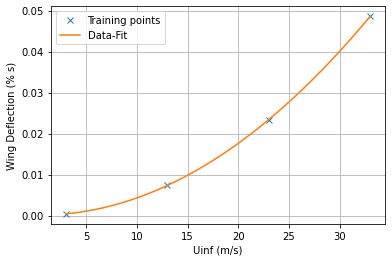

In [21]:
fig2, ax = plt.subplots()

ax.plot(x,wingDef_nonDim_train,'x')
ax.plot(xp,yp)

ax.legend(["Training points","Data-Fit"])
ax.grid(True)
ax.set_ylabel('Wing Deflection (% s)')
ax.set_xlabel('Uinf (m/s)')




## Get the errors from testing data

In [22]:
x_test = vel_test

Text(0.5, 0, 'Uinf (m/s)')

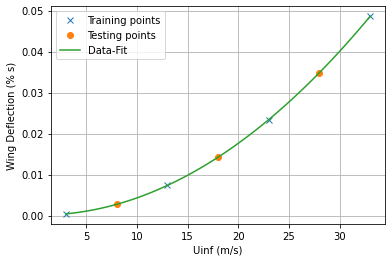

In [24]:
# Plot the points on the graph
fig3, ax = plt.subplots()

ax.plot(x,wingDef_nonDim_train,'x')
ax.plot(x_test,wingDef_nonDim_test,'o')
ax.plot(xp,yp)


ax.legend(["Training points","Testing points","Data-Fit"])
ax.grid(True)
ax.set_ylabel('Wing Deflection (% s)')
ax.set_xlabel('Uinf (m/s)')

In [26]:
# Calculate the generalisation error for a second order 
k = 2
error = 0;
for i in range(len(x_test)):
    btest = polynomial_basis(k,np.array([x_test[i]]))
    ys = np.dot(btest,params)
    error += (ys-wingDef_nonDim_test[i])**2
error = error/len(x_test)

print(error)

[[1.37737699e-09]]


## Testing error for different polynomial basis

Using a third order polynomial

In [29]:
k = 3
x = vel_train
b = polynomial_basis(k,x)
bpinv = np.linalg.pinv(b)
params = bpinv*wingDef_nonDim_train

xp = np.linspace(x[0],x[len(x)-1],100)
yp3 = np.zeros([len(xp),])
for i in range(len(yp3)):
    btest = polynomial_basis(k,np.array([xp[i]]))
    yp3[i] = np.dot(btest,params)



Get the error

In [30]:
error3 = 0;
for i in range(len(x_test)):
    btest = polynomial_basis(k,np.array([x_test[i]]))
    ys = np.dot(btest,params)
    error3 += (ys-wingDef_nonDim_test[i])**2
error3 = error3/len(x_test)


Using a fourth order polynomial

In [31]:
k = 4
# x is already defined
b = polynomial_basis(k,x)
bpinv = np.linalg.pinv(b)
params = bpinv*wingDef_nonDim_train

xp = np.linspace(x[0],x[len(x)-1],100)
yp4 = np.zeros([len(xp),])
for i in range(len(yp4)):
    btest = polynomial_basis(k,np.array([xp[i]]))
    yp4[i] = np.dot(btest,params)



In [32]:
error4 = 0;
for i in range(len(x_test)):
    btest = polynomial_basis(k,np.array([x_test[i]]))
    ys = np.dot(btest,params)
    error4 += (ys-wingDef_nonDim_test[i])**2
error4 = error4/len(x_test)

Text(0.5, 0, 'Uinf (m/s)')

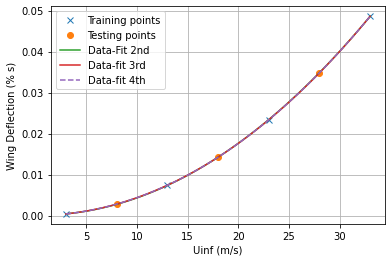

In [33]:
# Plot the points on the graph
fig4, ax = plt.subplots()

ax.plot(x,wingDef_nonDim_train,'x')
ax.plot(x_test,wingDef_nonDim_test,'o')
ax.plot(xp,yp)
ax.plot(xp,yp3)
ax.plot(xp,yp4,'--')

ax.legend(["Training points","Testing points","Data-Fit 2nd","Data-fit 3rd","Data-fit 4th"])
ax.grid(True)
ax.set_ylabel('Wing Deflection (% s)')
ax.set_xlabel('Uinf (m/s)')

## Print errors

In [34]:
print('2nd ', error)
print('3rd ', error3)
print('4th ', error4)

2nd  [[1.37737699e-09]]
3rd  [[1.50804784e-10]]
4th  [[8.45388461e-11]]
